### This notebook explores the building energy dataset provided by Arlington County, the exploratory questions were ask and answer in following:
* How much total energy is consumed every 6 years?
* What percentage of the total energy consumption comes from each calendar year?
* Which locations are the top energy consumers?
* how does energy consumption vary across different facility types?
* How does energy usage grow year over year, and what is the annual percentage increase?
* What is the energy usage per square foot across different locations?
* What is the cumulative energy consumption over every 3-year period?



In [75]:
import pandas as pd
import matplotlib.pyplot as plt

In [76]:
building_energy = pd.read_json("Data Source\Building+Energy+Usage.json")
building_energy.head()

,Place Code,Place Name,Address,Year,Complete Year,Floor Area (square feet),Electric (KWH),Natural Gas (Therm),Use Type
0,ARLINGTONMILL,Arlington Mill,"909 S Dinwiddie St, Arlington, VA",2012,false,72335.0,0,1.2,Community-Rec-Center
1,ARLINGTONMILL,Arlington Mill,"909 S Dinwiddie St, Arlington, VA",2013,true,72335.0,992280,41661.3,Community-Rec-Center
2,ARLINGTONMILL,Arlington Mill,"909 S Dinwiddie St, Arlington, VA",2014,true,72335.0,1243080,33748,Community-Rec-Center
3,ARLINGTONMILL,Arlington Mill,"909 S Dinwiddie St, Arlington, VA",2015,true,72335.0,1143580,26507.1,Community-Rec-Center
4,ARLINGTONMILL,Arlington Mill,"909 S Dinwiddie St, Arlington, VA",2016,true,72335.0,1099520,23836.9,Community-Rec-Center


In [77]:
building_energy.describe()

,Year,Floor Area (square feet)
count,1362.000000,1.362000e+03
mean,2009.602056,5.349489e+04
std,5.321709,1.421370e+05
min,2000.000000,1.000000e+03
25%,2005.000000,5.000000e+03
50%,2010.000000,1.411800e+04
75%,2014.000000,2.940400e+04
max,2018.000000,1.050000e+06


In [78]:
building_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1362 entries, 0 to 1361
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Place Code                1362 non-null   object 
 1   Place Name                1362 non-null   object 
 2   Address                   1362 non-null   object 
 3   Year                      1362 non-null   int64  
 4   Complete Year             1362 non-null   object 
 5   Floor Area (square feet)  1362 non-null   float64
 6   Electric (KWH)            1362 non-null   object 
 7   Natural Gas (Therm)       1362 non-null   object 
 8   Use Type                  1362 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 95.9+ KB


In [79]:
print(f'This dataset is range from {building_energy.Year.min()} to {building_energy.Year.max()}')

This dataset is range from 2000 to 2018


#### Replace true and false for [Complete Year] to 1 and 0

In [80]:
building_energy['Complete Year'].replace({'true':1,'false':0},inplace=True)


#### Create new column [total_energy_use] and set data type to integer for energy columns

In [81]:
building_energy['Electric (KWH)'] = pd.to_numeric(building_energy['Electric (KWH)'], errors='coerce')
building_energy['Natural Gas (Therm)'] = pd.to_numeric(building_energy['Natural Gas (Therm)'], errors='coerce')
building_energy.dropna(inplace= True)
building_energy['total_energy_use'] = building_energy['Electric (KWH)'] + building_energy['Natural Gas (Therm)']
building_energy['total_energy_use']


0              1.2
1        1033941.3
2        1276828.0
3        1170087.1
4        1123356.9
           ...    
1357    27506566.3
1358    27311741.2
1359    28431574.0
1360    28907456.0
1361    29872025.3
Name: total_energy_use, Length: 1355, dtype: float64

#### How much total energy is consumed every 6 years?



In [82]:
bins = [2000, 2005, 2011, 2018]
labels = ['2000-2005', '2006-2011', '2012-2018'] 

building_energy['year_range'] = pd.cut(building_energy['Year'], bins=bins, labels=labels, right=True)

building_energy.groupby('year_range')[['Electric (KWH)','Natural Gas (Therm)']].sum().reset_index()


,year_range,Electric (KWH),Natural Gas (Therm)
0,2000-2005,2.951576e+08,3.698284e+06
1,2006-2011,4.469285e+08,4.952710e+06
2,2012-2018,4.494207e+08,5.630612e+06


#### What percentage of the total energy consumption comes from each calendar year?

In [83]:
total_energy_use = building_energy['total_energy_use'].sum()
yr_total_energy_pct = building_energy.groupby('Year')['total_energy_use'].sum().reset_index()
yr_total_energy_pct['pct_to_total'] = (yr_total_energy_pct['total_energy_use']/total_energy_use).round(4)
yr_total_energy_pct[['Year','pct_to_total']].sort_values(by='pct_to_total', ascending=False)[:10].reset_index(drop=True)

,Year,pct_to_total
0,2014,0.0638
1,2015,0.0635
2,2013,0.0634
3,2009,0.0625
4,2008,0.0623
5,2007,0.0620
6,2010,0.0613
7,2011,0.0602
8,2012,0.0602
9,2006,0.0551


#### Which locations are the top energy consumers?

In [84]:
building_energy.groupby('Place Name')['Electric (KWH)'].sum().reset_index().sort_values('Electric (KWH)', ascending=False)[:10].reset_index(drop=True)

,Place Name,Electric (KWH)
0,Water Pollution Control Plant,4.219595e+08
1,Courts Police,1.053404e+08
2,Detention Center (Jail),1.013482e+08
3,Courthouse Plaza,9.424237e+07
4,OLD - 3033 Wilson,5.519260e+07
5,Ballston Ice Rink,5.309820e+07
6,Ballston Garage,3.590862e+07
7,Central Library,3.516310e+07
8,Sequoia I,3.084996e+07
9,Court Square West,2.474000e+07


##### How does energy consumption vary across different facility types?

In [85]:
building_energy.groupby('Use Type')['Electric (KWH)'].sum().reset_index().sort_values('Electric (KWH)', ascending=False).reset_index(drop=True)

,Use Type,Electric (KWH)
0,Specialty,4.887798e+08
1,Public-Safety,2.446213e+08
2,Offices,1.536670e+08
3,Community-Rec-Center,1.455654e+08
4,Human-Services,9.034353e+07
5,Libraries,4.146826e+07
6,Parking-Garage,3.460246e+07
7,Residential-Housing,2.070171e+07
8,Storage,6.072106e+06
9,Transit-Operations,3.032940e+06


#### How does energy usage grow year over year, and what is the annual percentage increase?

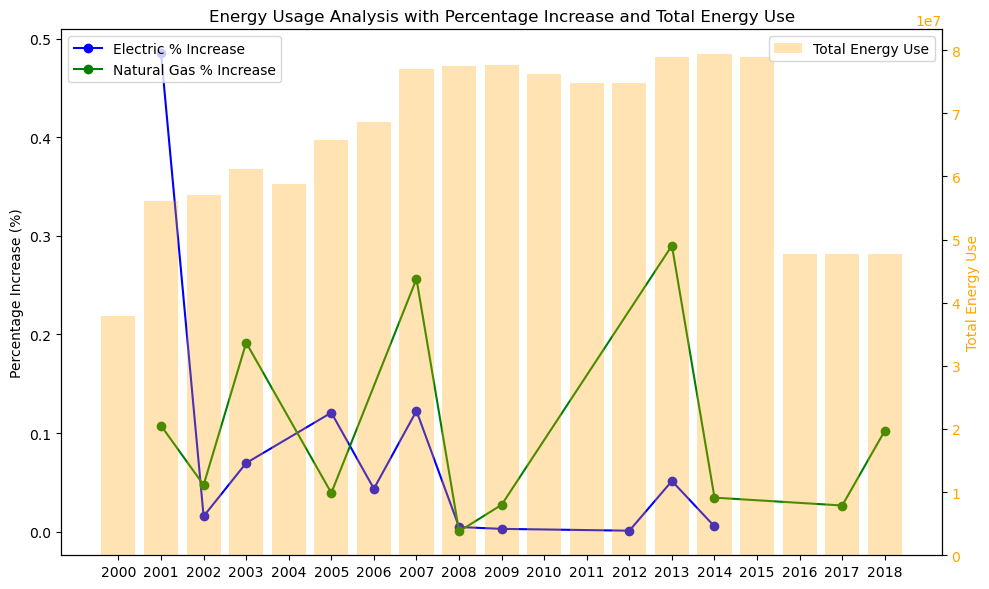

In [86]:

group_by_year = building_energy.groupby('Year')[['Electric (KWH)','Natural Gas (Therm)']].sum()
pct_change = group_by_year.pct_change()
pct_change.columns = ['electric%_incr', 'natural_gas%_incr']

electric_incr_yr = pct_change[pct_change['electric%_incr'] > 0 ][['electric%_incr']]
gas_incr_yr = pct_change[pct_change['natural_gas%_incr'] > 0 ][['natural_gas%_incr']]

total_energy_yr = building_energy.groupby('Year')['total_energy_use'].sum().reset_index()

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(electric_incr_yr, label='Electric % Increase', marker='o', color='blue')
ax1.plot(gas_incr_yr, label='Natural Gas % Increase', marker='o', color='green')
ax1.set_ylabel('Percentage Increase (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()

ax2.bar(total_energy_yr['Year'], total_energy_yr['total_energy_use'], alpha=0.3, label='Total Energy Use', color='orange')
ax2.set_ylabel('Total Energy Use', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

plt.xticks(building_energy['Year'].unique(), labels=building_energy['Year'].unique())
plt.title('Energy Usage Analysis with Percentage Increase and Total Energy Use')
plt.tight_layout()


#### How has the average energy use per year changed over time?

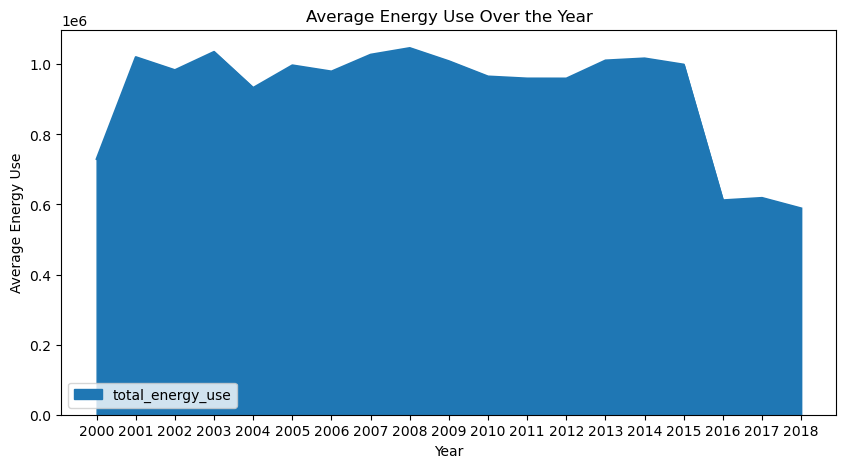

In [87]:
avg_per_yr = building_energy.groupby('Year')['total_energy_use'].mean().reset_index()

avg_per_yr.plot(kind='area', x='Year',figsize=(10,5),title='Average Energy Use Over the Year')
plt.ylabel('Average Energy Use')
plt.xticks(avg_per_yr.Year,labels=avg_per_yr.Year);

#### What is the energy usage per square foot across different locations?

Text(0.5, 0, 'Sq. ft.')

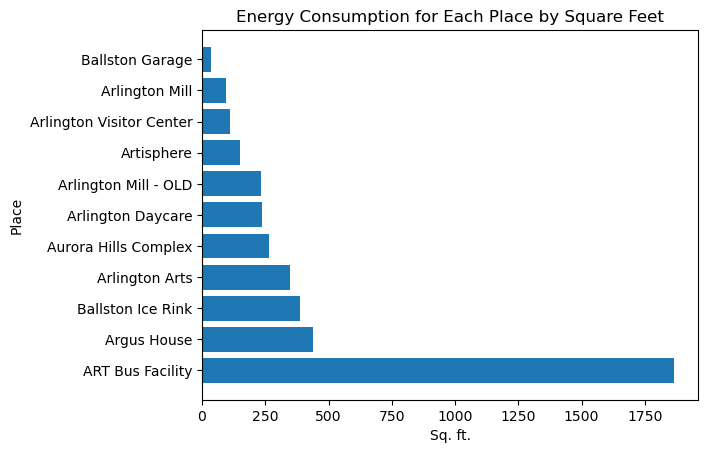

: 

In [ ]:
sum_energy_use = building_energy.groupby('Place Name')['total_energy_use'].sum().reset_index(name='sum_energy')
drop_duplicate_df = building_energy.drop_duplicates(subset=['Place Name'])
sum_energy_use = sum_energy_use.merge(drop_duplicate_df,on='Place Name')

sum_energy_use['energy_per_sq_ft'] = (sum_energy_use['sum_energy'] / sum_energy_use['Floor Area (square feet)']).round(2)
energy_per_sq = sum_energy_use.loc[:10,['Place Name','energy_per_sq_ft']].sort_values(by='energy_per_sq_ft', ascending=False)

plt.barh(data=energy_per_sq,y='Place Name', width='energy_per_sq_ft')
plt.title('Energy Consumption for Each Place by Square Feet')
plt.ylabel('Place')
plt.xlabel('Sq. ft.')


#### What is the cumulative energy consumption over every 3-year window?

In [36]:
building_energy.groupby('Year')['total_energy_use'].sum().rolling(3).sum().reset_index().set_index('Year')

,total_energy_use
Year,
2000,NaN
2001,NaN
2002,1.511236e+08
2003,1.742726e+08
2004,1.769116e+08
2005,1.856837e+08
2006,1.931576e+08
2007,2.114527e+08
2008,2.230808e+08
